In [1]:
import matplotlib.pyplot as plt
import torch as tc
import math
import time
import cv2 as cv
import numpy as np

In [2]:
tc.set_default_dtype(tc.float64)

In [3]:
def plane(normal,point):
    return {"normal":tc.tensor([normal]).cuda(),
            "point":tc.tensor([point]).cuda(),
            "color":lambda M: tc.tensor([1,1,1]).type(tc.cuda.FloatTensor) if int(M[...,1]%2)==int(M[...,2]%2) else tc.tensor([0,0,0]).type(tc.cuda.FloatTensor)}
plan=[plane(normal=[0,0.0,-1],point=[0,0.0,200])]
normal=[plan[i]["normal"] for i in range(len(plan))]
normal=tc.cat(normal)
point=[plan[i]["point"] for i in range(len(plan))]
point=tc.cat(point)

(-0.5, 1023.5, 767.5, -0.5)

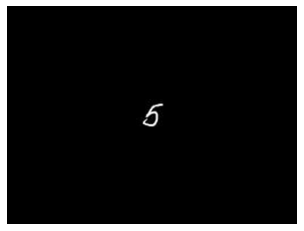

In [4]:
plane_img=cv.imread("mnist0.jpg",cv.IMREAD_GRAYSCALE)
# plane_img=cv.resize(plane_img,(768,768))
plane_img=tc.round(tc.tensor(plane_img).type(tc.FloatTensor))
import torch.nn.functional as F
plane_img=F.pad(plane_img,[int((1024-plane_img.size(1))/2),int((1024-plane_img.size(1))/2),int((768-plane_img.size(0))/2),int((768-plane_img.size(0))/2)])
plt.imshow(plane_img,"gray")
plt.axis("off")

In [5]:
#寻找交点距离
def plane_cross(module,ray_origin,ray_dir):
    dn=tc.squeeze(tc.mm(module["normal"],ray_dir.T))
    dis=tc.matmul(module["point"]-ray_origin,module["normal"].T)/dn
    dis.T[tc.abs(dn)<1e-6]=tc.inf
    return dis
#寻找最近交点距离
def shortest_dis(sence,ray_origin,ray_dir):
    a=tc.matmul(ray_origin,ray_dir.T).size()
    dis=(tc.ones(a)*tc.inf).cuda()
    index=(tc.zeros(a).type(tc.LongTensor)).cuda()
    for i in range(len(plan)):
        dis_s=plane_cross(sence[i],ray_origin,ray_dir)
        index[dis_s<dis]=i
        dis[dis_s<dis]=dis_s[dis_s<dis]
    return dis,index

In [6]:
#光源属性
souce={"position":tc.tensor([[-100,100,0]]).cuda(),"color":tc.tensor([[1,1,1]]).cuda()}
#Phong反射
ka,kd,ks,alpha=0.3,0.7,0.5,7
w,h=768,1024
pixl=2.6*10**-2#mm
lamda=5.32*10**-4
c=tc.min(point[:,2])
k=int(tc.max(point[:,2])-c)*10+1
phi=2*tc.pi*tc.rand(400,600,k)#0.1mm一个相位
pixl_num=32

In [7]:
w_mesh=tc.linspace(-(w/2-pixl_num/2)*pixl,(w/2-pixl_num/2)*pixl,int(w/pixl_num))
h_mesh=tc.linspace(-(h/2-pixl_num/2)*pixl,(h/2-pixl_num/2)*pixl,int(h/pixl_num))
[x,y]=tc.meshgrid(w_mesh,h_mesh)
origin=tc.zeros(int(w/pixl_num),int(h/pixl_num),3)
origin[:,:,0]=x
origin[:,:,1]=y
origin=origin.cuda()

D:\anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
w_mesh=tc.linspace(-(w/2-1/2)*pixl,(w/2-1/2)*pixl,w)
h_mesh=tc.linspace(-(h/2-1/2)*pixl,(h/2-1/2)*pixl,h)
[x,y]=tc.meshgrid(w_mesh,h_mesh)
origin_p=tc.zeros(w,h,3)
origin_p[:,:,0]=x
origin_p[:,:,1]=y
origin_p=origin_p.reshape(int(w/pixl_num),pixl_num,int(h/pixl_num),pixl_num,3)
origin_p=tc.permute(origin_p,[0,2,1,3,4])
origin_p=origin_p.cuda()
origin_p=tc.unsqueeze(origin_p,dim=-4)

In [9]:
#虚拟光线在视锥体底面上均匀取(四棱锥高设为1)
theta=math.asin(lamda/(2*pixl))
n=int(2*theta/math.pi*180/(1/60))
light_dir=tc.zeros(n**2,3)
x=tc.linspace(-math.tan(theta),math.tan(theta),n)
x,y=tc.meshgrid(x,x)
norm=tc.sqrt(x**2+y**2+1)
light_dir[:,0]=(x/norm).view(-1)
light_dir[:,1]=(y/norm).view(-1)
light_dir[:,2]=(1/norm).view(-1)

In [10]:
%%time
b=len(light_dir)
light_dir=light_dir.cuda()
plane_img=(plane_img/tc.max(plane_img)).cuda()
image=tc.zeros(w,h,dtype=tc.cfloat).cuda()
pix=(pixl*w+2*math.tan(theta)*plan[0]["point"][...,2])/w
# color_image=tc.zeros(w,h,3,dtype=tc.cfloat).cuda()
########
for i in range(int(w/pixl_num)):
    for j in range(int(h/pixl_num)):
        dis,index=shortest_dis(plan,origin[i,j].reshape(1,3),light_dir)
        coord=tc.unsqueeze(origin[i,j].reshape(1,3),dim=-2)+light_dir*tc.unsqueeze(dis,dim=-1)
#         L=(souce["position"]-coord)/tc.unsqueeze(tc.norm(souce["position"]-coord,dim=-1),dim=-1)
# #         N=(coord-center[index])/tc.unsqueeze(tc.norm(coord-center[index],dim=-1),dim=-1)
#         N=normal
#         L_N=tc.squeeze(tc.matmul(tc.unsqueeze(L,dim=-2),N.T))
#         R=2*L_N.unsqueeze(dim=-1)*N-L
#         V=tc.ones(R.size()).cuda()*(-light_dir)
        img_A=plane_img[((coord[...,0])/pix+w/2).type(tc.LongTensor),((coord[...,1])/pix+h/2).type(tc.LongTensor)]
        A=img_A#*(ka+kd**tc.clip(L_N,0)+ks*tc.squeeze(tc.clip(tc.matmul(tc.unsqueeze(R,dim=-2),tc.unsqueeze(V,dim=-1)),0)**alpha))
        #阴影
        #     shadow_dis=shadow(sence,coord,L,index)
        #     shadow_dis[shadow_dis== -tc.inf]=tc.inf
        #     shadow_dis[tc.isnan(shadow_dis)]=tc.inf
        #     A[shadow_dis!=tc.inf]=ka
        #
        coord[coord==tc.inf]=0
        coord[coord== -tc.inf]=0
        coord[tc.isnan(coord)]=0
        coord[...,2][coord[...,2]==0]=c
        coord=coord.unsqueeze(dim=-2).unsqueeze(dim=-2)
        di=tc.norm(origin_p[i][j]-coord,dim=-1)
        x1=coord[...,0]-coord[...,2]*math.tan(theta)
        x2=coord[...,0]+coord[...,2]*math.tan(theta)
        y1=coord[...,1]-coord[...,2]*math.tan(theta)
        y2=coord[...,1]+coord[...,2]*math.tan(theta)
        H=A.unsqueeze(dim=-1).unsqueeze(dim=-1)/di*tc.exp(1j*(2*tc.pi/lamda*di+phi[(10*coord[...,0]+phi.size(0)/2).type(tc.LongTensor),(10*coord[...,1]+phi.size(1)/2).type(tc.LongTensor),(10*(coord[...,2]-c)).type(tc.LongTensor)].cuda()))
        H[(origin_p[i][j][...,0]<x1)&(origin_p[i][j][...,0]>x2)&(origin_p[i][j][...,1]<y1)&(origin_p[i][j][...,1]>y2)]=0
        H[H==tc.inf]=0
        H[H== -tc.inf]=0
        H[tc.isnan(H)]=0
        image[pixl_num*i:pixl_num*(i+1),pixl_num*j:pixl_num*(j+1)]=tc.sum(H,dim=-3).reshape(pixl_num,pixl_num)

Wall time: 7.56 s


In [13]:
tc.save(image.cpu(),'复振幅8.pth')

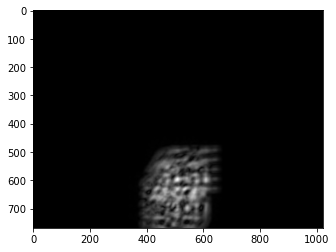

In [10]:
img=image.cpu()
plt.imshow(tc.abs(img),"gray")

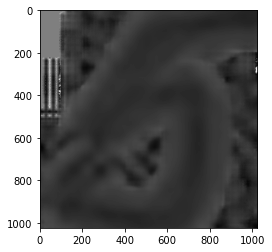

In [11]:
plt.imshow(tc.angle(img),"gray")

In [20]:
I=np.abs(np.array(img))
window_name="show"
cv.namedWindow(window_name,0)
cv.setWindowProperty(window_name,cv.WND_PROP_FULLSCREEN,cv.WINDOW_FULLSCREEN)
# cv.SetWindowLong(window_name, cv.GWL_STYLE, cv.GetWindowLong(window_name, cv.GWL_EXSTYLE) | cv.WS_EX_TOPMOST);
# cv.ShowWindow(window_name, SW_SHOW);
cv.moveWindow(window_name,0,0)
cv.resizeWindow(window_name,h,w)
I=(I-np.min(I))/(np.max(I)-np.min(I))
cv.imshow(window_name,I)
cv.waitKey(0)

-1

In [34]:
cv.destroyAllWindows()

In [30]:
# %%time
b=len(light_dir)
light_dir=light_dir.cuda()
plane_img=(plane_img/tc.max(plane_img)).cuda()
image=tc.zeros(w,h,dtype=tc.cfloat).cuda()
# color_image=tc.zeros(w,h,3,dtype=tc.cfloat).cuda()
########
pix=(pixl*w+2*math.tan(theta)*plan[0]["point"][...,2])/w
for i in range(int(w/pixl_num)):
    for j in range(int(h/pixl_num)):
        dis,index=shortest_dis(plan,origin_p[i,j],light_dir)
        coord=tc.unsqueeze(origin_p[i,j],dim=-2)+light_dir*tc.unsqueeze(dis,dim=-1)
#         L=(souce["position"]-coord)/tc.unsqueeze(tc.norm(souce["position"]-coord,dim=-1),dim=-1)
# #         N=(coord-center[index])/tc.unsqueeze(tc.norm(coord-center[index],dim=-1),dim=-1)
#         N=normal
#         L_N=tc.squeeze(tc.matmul(tc.unsqueeze(L,dim=-2),N.T))
#         R=2*L_N.unsqueeze(dim=-1)*N-L
#         V=tc.ones(R.size()).cuda()*(-light_dir)
        img_A=plane_img[((coord[...,0])/pix+w/2).type(tc.LongTensor),((coord[...,1])/pix+h/2).type(tc.LongTensor)]
        A=img_A#*(ka+kd**tc.clip(L_N,0)+ks*tc.squeeze(tc.clip(tc.matmul(tc.unsqueeze(R,dim=-2),tc.unsqueeze(V,dim=-1)),0)**alpha))
#         A=plane_img[((coord[...,0])/0.032+w/2).type(tc.LongTensor),((coord[...,1])/0.032+h/2).type(tc.LongTensor)]
        #阴影
        #     shadow_dis=shadow(sence,coord,L,index)
        #     shadow_dis[shadow_dis== -tc.inf]=tc.inf
        #     shadow_dis[tc.isnan(shadow_dis)]=tc.inf
        #     A[shadow_dis!=tc.inf]=ka
        #
        coord[coord==tc.inf]=0
        coord[coord== -tc.inf]=0
        coord[tc.isnan(coord)]=0
        coord[...,2][coord[...,2]==0]=c
#         coord=coord.unsqueeze(dim=-2).unsqueeze(dim=-2)
#         di=tc.norm(origin_p[i][j]-coord,dim=-1)
#         x1=coord[...,0]-coord[...,2]*math.tan(theta)
#         x2=coord[...,0]+coord[...,2]*math.tan(theta)
#         y1=coord[...,1]-coord[...,2]*math.tan(theta)
#         y2=coord[...,1]+coord[...,2]*math.tan(theta)
        H=A/dis*tc.exp(1j*(2*tc.pi/lamda*dis))#+phi[(10*coord[...,0]+phi.size(0)/2).type(tc.LongTensor),(10*coord[...,1]+phi.size(1)/2).type(tc.LongTensor),(10*(coord[...,2]-c)).type(tc.LongTensor)].cuda()))
#.unsqueeze(dim=-1).unsqueeze(dim=-1)
    #         H[(origin_p[i][j][...,0]<x1)&(origin_p[i][j][...,0]>x2)&(origin_p[i][j][...,1]<y1)&(origin_p[i][j][...,1]>y2)]=0
        H[H==tc.inf]=0
        H[H== -tc.inf]=0
        H[tc.isnan(H)]=0
        image[pixl_num*i:pixl_num*(i+1),pixl_num*j:pixl_num*(j+1)]=tc.sum(H,dim=-1)

KeyboardInterrupt: 